In [1]:
using LCIO
using GRUtils
using FastJet
using CxxWrap: StdVector
using LinearAlgebra

# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294

In [12]:
jetMassList = Float64[]
wMuonNJetList = Float64[]
wMuonNParticleList = Float64[]

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL (1).slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            if getGeneratorStatus(particle) != 1
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            # FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            push!(particles, PseudoJet(p[1], p[2], p[3], E))
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 4)
        push!(wMuonNJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(wMuonNParticleList, length(constituents(j)))
        end
    end
    println("read ", iEvent, " events")
end

#histogram(nJetList)
#savefig("nJets.pdf")

#histogram(nParticleList, nbins=100)
#savefig("nParticles.pdf")


read 100000 events


In [3]:
function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end


function zMuonIndices(data, threshold)
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    for particle in getCollection(data, "MCParticle")
        iParticle += 1
        if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
            if getCharge(particle)==1
                push!(posMuonList, [particle, iParticle])
            elseif getCharge(particle)==-1
                push!(negMuonList, [particle, iParticle])
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    indices = [candidatePair[1][2], candidatePair[2][2]]
    if abs(candidateDiff)>threshold
        indices=[0,0]
    end
    return indices
end

zMuonIndices (generic function with 1 method)

In [14]:
nParticleList = Float64[]
nJetList = Float64[]
JetMassList = Float64[]

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL (1).slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        muon_from_Z = zMuonIndices(event, 10)
        particles = PseudoJet[]
        for particle in getCollection(event, "MCParticle")
            iParticle+=1
            if getGeneratorStatus==1 || iParticle in muon_from_Z
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            push!(particles, PseudoJet(p[1], p[2], p[3], E))
        end
        cs = ClusterSequence(StdVector(particles), jet_def)
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        for j in jets
            push!(nParticleList, length(constituents(j)))
            jetmass = 0
            for c in constituents(j)
                jetmass+=m(c)
            end
            push!(JetMassList, jetmass)
        end
    end
    println("read ", iEvent, " events")
end

histogram(nJetList)

UndefVarError: UndefVarError: m not defined

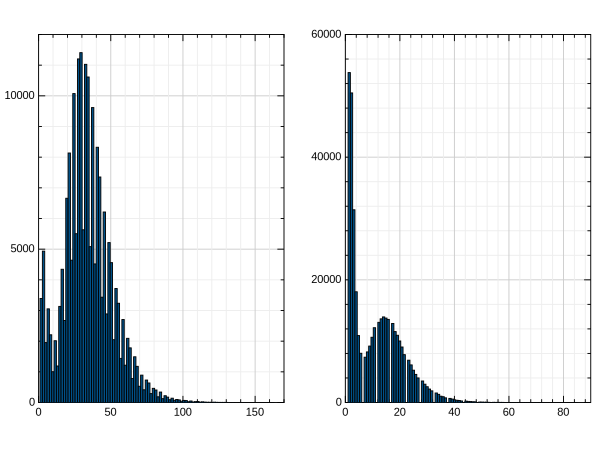

In [13]:
subplot(1,2,1)
histogram(nParticleList, nbins=100)

subplot(1,2,2)
histogram(wMuonNParticleList, nbins=100)